In [2]:
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
import re
import os
from PIL import Image 
import math
from skimage.io import imread

# 기존 Tesseract 코드

In [ ]:
# ------------------------- OCR_v1 -------------------------
# OCR 버전마다 전처리 과정이 다름
def OCR_pn(img):
    img = cv2.imread(img) # 이미지 로드
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # 배경에 그레이 적용
    gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC) # 사이즈 정규화(키우기)
    blur = cv2.GaussianBlur(gray, (5,5), 0) # 이미지에 블러 처리

    # ------------------- 기울기 조정 start -------------------
    canny = cv2.Canny(blur, 700, 350, apertureSize = 5, L2gradient = True) # 이미지 외곽선만 추출
    lines = cv2.HoughLinesP(canny, 1, np.pi / 180, 50, minLineLength = 3, maxLineGap = 150) # 직선 찾기

    angle = 0
    maxdim = 0
    # 각도 조정
    if not (lines is None):
        for i in lines:
            xdim = i[0][2] - i[0][0]
            ydim = i[0][3] - i[0][1]
            iangle = math.atan2(ydim, xdim)*180/np.pi
            dim = math.sqrt((xdim * xdim) + (ydim * ydim))
            if abs(angle) < 40 and maxdim < dim:
                maxdim = dim
                angle =iangle

    roih, roiw, roic = img.shape
    matrix = cv2.getRotationMatrix2D((roiw/2, roih/2), angle, 1)
    roi = cv2.warpAffine(img, matrix, (roiw, roih))
    # ------------------- 기울기 조정 fin -------------------

    roi = cv2.resize(roi, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    blur_2 = cv2.GaussianBlur(roi, (5,5), 0)
    
    plate_num = ""
    try:
        # tesseract OCR 적용
        text = pytesseract.image_to_string(blur_2, config='-c tessedit_char_whitelist=0123456789 --psm 7 --oem 1') # whitelist: 숫자만 인식
        plate_num = re.sub('[\W_]+', '', text) # 특수문자 제거
    except:
        text = None
        
    plate_num = re.sub('[\W_]+', '', text)   
    return plate_num[-4:]


# ------------------------- OCR_v2 -------------------------
def OCR_pn2(img):
    img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    
    plate_num = ""
    try:
        text = pytesseract.image_to_string(blur, config='-c tessedit_char_whitelist=0123456789 --psm 7 --oem 1')
        plate_num = re.sub('[\W_]+', '', text)            
    except:
        text = None

    plate_num = re.sub('[\W_]+', '', text)   
    return plate_num[-4:]


# ------------------------- OCR_v3 -------------------------
def OCR_pn3(img):
    img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # ------------------- 기울기 조정 start -------------------
    canny = cv2.Canny(blur, 700, 350, apertureSize = 5, L2gradient = True)
    lines = cv2.HoughLinesP(canny, 1, np.pi / 180, 50, minLineLength = 3, maxLineGap = 150)

    angle = 0
    maxdim = 0
    if not (lines is None):
        for i in lines:
            xdim = i[0][2] - i[0][0]
            ydim = i[0][3] - i[0][1]
            iangle = math.atan2(ydim, xdim)*180/np.pi
            dim = math.sqrt((xdim * xdim) + (ydim * ydim))
            if abs(angle) < 40 and maxdim < dim:
                maxdim = dim
                angle =iangle

    roih, roiw, roic = img.shape
    matrix = cv2.getRotationMatrix2D((roiw/2, roih/2), angle, 1)
    roi = cv2.warpAffine(img, matrix, (roiw, roih))
    # ------------------- 기울기 조정 fin -------------------

    gray_2 = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    gray_2 = cv2.resize(gray_2, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    blur_2 = cv2.GaussianBlur(gray_2, (5,5), 0)

    ## 이미지 흑백 대조하기, 최적 임계값을 자동으로 추출하는 Otsus 사용
    ret, thresh = cv2.threshold(blur_2, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    ## 확장을 위한 커널 생성
    rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    ## 글씨 이미지 크기 확장
    dilation = cv2.dilate(thresh, rect_kern, iterations = 1)

    blur_3 = cv2.GaussianBlur(dilation, (5,5), 0)
    
    plate_num = ""
    try:
        text = pytesseract.image_to_string(blur_3, config='-c tessedit_char_whitelist=0123456789 --psm 7 --oem 1')
        plate_num = re.sub('[\W_]+', '', text)            
    except:
        text = None
    
    plate_num = re.sub('[\W_]+', '', text)   
    return plate_num[-4:]
            
        
# ------------------------- OCR_v4 -------------------------
def OCR_bn(img):
    img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    
    ## 이미지 흑백 대조하기, 최적 임계값을 자동으로 추출하는 Otsus 사용
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    ## 확장을 위한 커널 생성
    rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    ## 글씨 이미지 크기 확장
    dilation = cv2.dilate(thresh, rect_kern, iterations = 1)
    blur_2 = cv2.GaussianBlur(dilation, (5,5), 0)
    
    plate_num = ""
    try:
        text = pytesseract.image_to_string(blur_2, config='-c tessedit_char_whitelist=0123456789 --psm 7 --oem 1')            
    except:
        text = None
        
    plate_num = re.sub('[\W_]+', '', text)   
    return plate_num[-4:]

# 이미지 후처리 테스트
## 1. Tesseract

In [ ]:
def OCR(img):
    plate_num = ""
    try:
        text = pytesseract.image_to_string(img, config='-c tessedit_char_whitelist=0123456789 --psm 7 --oem 1')            
    except:
        text = None
        
    plate_num = re.sub('[\W_]+', '', text)   
    return plate_num[-4:]

In [ ]:
import time
start = time.time()

bus_num_fr_path = 'yolov5/runs/hub/exp/crops/bus_num_fr/'
file_list = os.listdir(bus_num_fr_path)
result_list = list()

for file in file_list:
    folder_name = file.split(' ')[0]
    try:
        img = cv2.imread(os.path.join(bus_num_fr_path, file))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        edged = cv2.Canny(blurred, 700, 350, apertureSize = 5, L2gradient = True)
        result = OCR(edged)
    except:
        result = 'None'

    if result == folder_name:
        result_list.append(1)
    else:
        result_list.append(0)

print(time.time() - start)
sum(result_list)/len(result_list)

## 2. easyocr

In [ ]:
import time
import easyocr

bus_num_fr_path = 'yolov5/runs/hub/exp/crops/bus_num_fr/'
file_list = os.listdir(bus_num_fr_path)
result_list = list()
reader = easyocr.Reader(['ar'])

start = time.time()
for file in file_list:
    folder_name = file.split(' ')[0]
    try:
        img = cv2.imread(os.path.join(bus_num_fr_path, file))
        blurred = cv2.GaussianBlur(img, (3, 3), 0)
        result = reader.readtext(blurred)[0][-2]
        result = re.findall('\d+', result)
    except:
        result = 'None'

    if folder_name in result:
        result_list.append(1)
    else:
        result_list.append(0)

print(time.time() - start)
sum(result_list)/len(result_list)

## 필터 테스트

In [ ]:
test_img = 'yolov5/runs/hub/exp/crops/bus_num_fr/2015 (26).jpg'

img = cv2.imread('yolov5/runs/hub/exp/crops/bus_num_fr/2015 (26).jpg')

plt.imshow(img)

### 1. GaussianBlur test

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

fig = plt.figure()
sub1 = fig.add_subplot(2,2,1)
sub2 = fig.add_subplot(2,2,2)
sub3 = fig.add_subplot(2,2,3)
sub4 = fig.add_subplot(2,2,4)


sub1.imshow(gray, cmap='gray')
blurred1 = cv2.GaussianBlur(gray, (1, 1), 0)
sub2.imshow(blurred1, cmap='gray')
blurred2 = cv2.GaussianBlur(gray, (3, 3), 0) ## 이 조합 제일 좋음 0.49
sub3.imshow(blurred2, cmap='gray')
blurred3 = cv2.GaussianBlur(gray, (5, 5), 0)
sub4.imshow(blurred3, cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

fig = plt.figure()
sub1 = fig.add_subplot(2,2,1)
sub2 = fig.add_subplot(2,2,2)
sub3 = fig.add_subplot(2,2,3)
sub4 = fig.add_subplot(2,2,4)


sub1.imshow(gray, cmap='gray')

blurred1 = cv2.GaussianBlur(gray, (1, 1), 0)
edged1 = cv2.Canny(blurred1, 700, 350, apertureSize = 5, L2gradient = True)
sub2.imshow(edged1, cmap='gray')

blurred2 = cv2.GaussianBlur(gray, (3, 3), 0)
edged2 = cv2.Canny(blurred, 10, 50, 255)
sub3.imshow(edged2, cmap='gray')

blurred3 = cv2.GaussianBlur(gray, (5, 5), 0)
edged3 = cv2.Canny(blurred, 10, 50, 255)
sub4.imshow(edged3, cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
edged = cv2.Canny(blurred, 10, 50, 255)

### 2. HE test

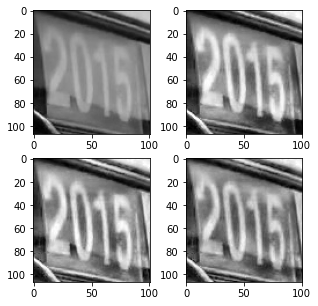

In [151]:
test_img = 'yolov5/runs/hub/exp/crops/bus_num_fr/2015 (26).jpg'
img = cv2.imread(test_img)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(5, 5))
fig_1 = fig.add_subplot(2,2,1)
fig_2 = fig.add_subplot(2,2,2)
fig_3 = fig.add_subplot(2,2,3)
fig_4 = fig.add_subplot(2,2,4)

# create a CLAHE object (Arguments are optional).
clahe1 = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(3,3))
cl1 = clahe1.apply(gray_image)

clahe2 = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(5,5))
cl2 = clahe2.apply(gray_image)

clahe3 = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(7,7))
cl3 = clahe3.apply(gray_image)

fig_1.imshow(gray_image, cmap='gray')
fig_2.imshow(cl1, cmap='gray')
fig_3.imshow(cl2, cmap='gray')
fig_4.imshow(cl3, cmap='gray')
plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 5))
fig_1 = fig.add_subplot(2,2,1)
fig_2 = fig.add_subplot(2,2,2)
fig_3 = fig.add_subplot(2,2,3)
fig_4 = fig.add_subplot(2,2,4)

# create a CLAHE object (Arguments are optional).
clahe1 = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(2,2))
cl1 = clahe1.apply(gray_image)

clahe2 = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(2,2))
cl2 = clahe2.apply(gray_image)

clahe3 = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(2,2))
cl3 = clahe3.apply(gray_image)

fig_1.imshow(gray_image, cmap='gray')
fig_2.imshow(cl1, cmap='gray')
fig_3.imshow(cl2, cmap='gray')
fig_4.imshow(cl3, cmap='gray')
plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 5))
fig_1 = fig.add_subplot(2,2,1)
fig_2 = fig.add_subplot(2,2,2)
fig_3 = fig.add_subplot(2,2,3)
fig_4 = fig.add_subplot(2,2,4)

# create a CLAHE object (Arguments are optional).
clahe1 = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(2,2))
cl1 = clahe1.apply(gray_image)
edged1 = cv2.Canny(cl1, 10, 50, 255)

clahe2 = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(2,2))
cl2 = clahe2.apply(gray_image)
edged2 = cv2.Canny(cl2, 10, 50, 255)

clahe3 = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(2,2))
cl3 = clahe3.apply(gray_image)
edged3 = cv2.Canny(cl3, 10, 50, 255)

fig_1.imshow(gray_image, cmap='gray')
fig_2.imshow(edged1, cmap='gray')
fig_3.imshow(edged2, cmap='gray')
fig_4.imshow(edged3, cmap='gray')
plt.show()

### 3. contrast

In [23]:
def img_Contrast(img):
    # -----Converting image to LAB Color model----------------------------------- 
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) 
    # -----Splitting the LAB image to different channels------------------------- 
    l, a, b = cv2.split(lab) 
    # -----Applying CLAHE to L-channel------------------------------------------- 
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8)) 
    cl = clahe.apply(l) 
    # -----Merge the CLAHE enhanced L-channel with the a and b channel----------- 
    limg = cv2.merge((cl, a, b)) 
    # -----Converting image from LAB Color model to RGB model-------------------- 
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR) 
    return final

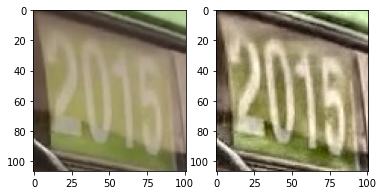

In [11]:
test_img = 'yolov5/runs/hub/exp/crops/bus_num_fr/2015 (26).jpg'
img = cv2.imread(test_img)
result = img_Contrast(img)
fig = plt.figure()

fig1 = fig.add_subplot(1,2,1)
fig2 = fig.add_subplot(1,2,2)

fig1.imshow(img)
fig2.imshow(result)

plt.show()

In [ ]:
import time
import easyocr

bus_num_fr_path = 'yolov5/runs/hub/exp/crops/bus_num_fr/'
file_list = os.listdir(bus_num_fr_path)
result_list = list()
reader = easyocr.Reader(['ar'])

start = time.time()
for file in file_list:
    folder_name = file.split(' ')[0]
    try:
        img = cv2.imread(os.path.join(bus_num_fr_path, file))
        # cont_img = img_Contrast(img)
        blurred = cv2.GaussianBlur(img, (3, 3), 0)
        result = reader.readtext(blurred)[0][-2]
        result = re.findall('\d+', result)
    except:
        result = 'None'

    if folder_name in result:
        result_list.append(1)
    else:
        result_list.append(0)

print(time.time() - start)
sum(result_list)/len(result_list)

 Basic Linear Transforms 
-------------------------
* Enter the alpha value [1.0-3.0]: 1
* Enter the beta value [0-100]: 20


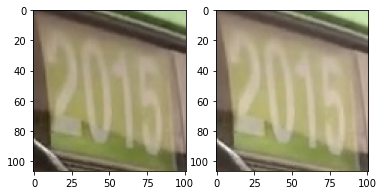

In [15]:
test_img = 'yolov5/runs/hub/exp/crops/bus_num_fr/2015 (26).jpg'
image = cv2.imread(test_img)

if image is None:
    print('Could not open or find the image: ', args.input)
    exit(0)
    
    
new_image = np.zeros(image.shape, image.dtype)
alpha = 1.0 # Simple contrast control
beta = 0    # Simple brightness control
# Initialize values
print(' Basic Linear Transforms ')
print('-------------------------')
try:
    alpha = float(input('* Enter the alpha value [1.0-3.0]: '))
    beta = int(input('* Enter the beta value [0-100]: '))
except ValueError:
    print('Error, not a number')
# Do the operation new_image(i,j) = alpha*image(i,j) + beta
# Instead of these 'for' loops we could have used simply:
# new_image = cv.convertScaleAbs(image, alpha=alpha, beta=beta)
# but we wanted to show you how to access the pixels :)
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        for c in range(image.shape[2]):
            new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
            
fig = plt.figure()

fig1 = fig.add_subplot(1,2,1)
fig2 = fig.add_subplot(1,2,2)

fig1.imshow(image)
fig2.imshow(new_image)

plt.show()

### 4. 감마 보정

감마값 : 1.8


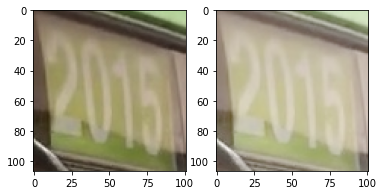

In [19]:
g = float(input("감마값 : "))
test_img = 'yolov5/runs/hub/exp/crops/bus_num_fr/2015 (26).jpg'
img = cv2.imread(test_img)
out = img.copy()

out = out.astype(np.float32)
out = ((out / 255) ** (1 / g)) * 255

out = out.astype(np.uint8)

fig = plt.figure()
fig1 = fig.add_subplot(1,2,1)
fig2 = fig.add_subplot(1,2,2)

fig1.imshow(img)
fig2.imshow(out)

plt.show()

### 5. otsu

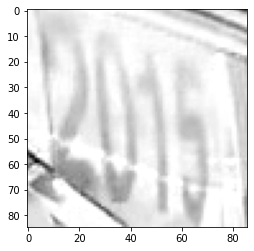

In [196]:
# image path
test_img = 'yolov5/runs/hub/exp/crops/bus_num_fr/2015 (23).jpg'

# Reading an image in default mode:
inputImage = cv2.imread(test_img)

#  색 반전
inputImage = 255 - inputImage

# Remove small noise via median:
filterSize = 3
imageMedian = cv2.medianBlur(inputImage, filterSize)

# Get local maximum:
kernelSize = 20 # 이 값을 변화하여 배경과 숫자를 구분
maxKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernelSize, kernelSize))
localMax = cv2.morphologyEx(imageMedian, cv2.MORPH_CLOSE, maxKernel, None, None, 1, cv2.BORDER_REFLECT101)

# Perform gain division
gainDivision = np.where(localMax == 0, 0, (inputImage/localMax))

# Clip the values to [0,255]
gainDivision = np.clip((255 * gainDivision), 0, 255)

# Convert the mat type from float to uint8:
gainDivision = gainDivision.astype("uint8") 

# Convert RGB to grayscale:
grayscaleImage = cv2.cvtColor(gainDivision, cv2.COLOR_BGR2GRAY)

plt.imshow(grayscaleImage, cmap='gray')

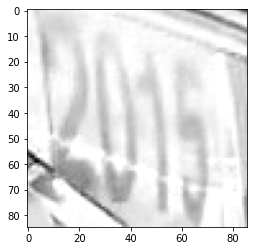

In [197]:
# Contrast Enhancement:
grayscaleImage = np.uint8(cv2.normalize(grayscaleImage, grayscaleImage, 0, 255, cv2.NORM_MINMAX))

plt.imshow(grayscaleImage, cmap='gray')

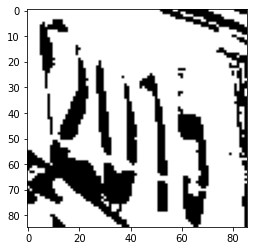

In [198]:
# Threshold via Otsu + bias adjustment:
threshValue, binaryImage = cv2.threshold(grayscaleImage, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

threshValue = 1 * threshValue
_, binaryImage = cv2.threshold(grayscaleImage, threshValue, 255, cv2.THRESH_BINARY)

plt.imshow(binaryImage, cmap='gray')

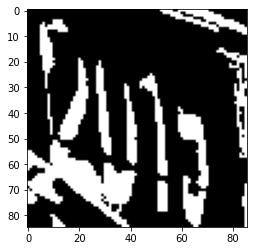

In [199]:
# Invert image:
binaryImage = 255 - binaryImage

# Perform an area filter on the binary blobs:
componentsNumber, labeledImage, componentStats, componentCentroids = \
cv2.connectedComponentsWithStats(binaryImage, connectivity=4)

# Set the minimum pixels for the area filter:
minArea = 10

# Get the indices/labels of the remaining components based on the area stat
# (skip the background component at index 0)
remainingComponentLabels = [i for i in range(1, componentsNumber) if componentStats[i][4] >= minArea]

# Filter the labeled pixels based on the remaining labels,
# assign pixel intensity to 255 (uint8) for the remaining pixels
filteredImage = np.where(np.isin(labeledImage, remainingComponentLabels) == True, 255, 0).astype("uint8")

plt.imshow(filteredImage, cmap='gray')